In [1]:
!pip install SentencePiece -q
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.4 MB/s eta 0:00:00


### Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn import metrics

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


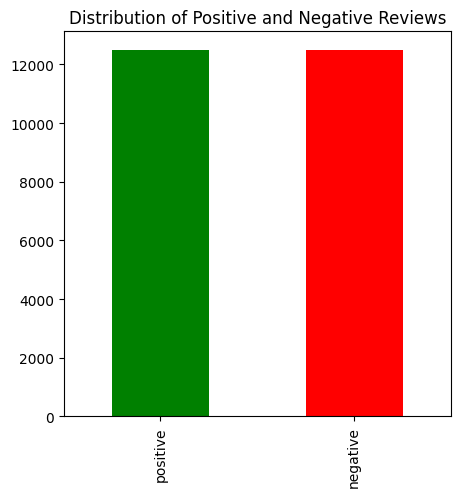

In [4]:
df = pd.read_csv(r"/content/drive/MyDrive/Georgian/Sem1/ML programming/Final project/imdb_reviews.csv")

df["sentiment"].value_counts().plot(kind='bar',
                                    color=['green','red'],
                                    title='Distribution of Positive and Negative Reviews',
                                    figsize=(5,5));

### Config

In [5]:
class Config:
  MAX_LEN = 384
  TRAIN_BATCH_SIZE = 8
  VALID_BATCH_SIZE = 4
  EPOCHS = 4
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  XLNet_PATH = "xlnet-base-cased"
  MODEL_PATH = "xlnetModel.bin"
  TRAINING_DATA = "/content/drive/MyDrive/Georgian/Sem1/ML programming/Final project/imdb_reviews.csv"

  TOKENIZER = transformers.XLNetTokenizer.from_pretrained(XLNet_PATH, do_lower_case = True)
  MODEL = transformers.XLNetModel.from_pretrained(XLNet_PATH, return_dict=True)

### Dataset

In [6]:
class DataProcess:
  def __init__(self, review):
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN
    self.review = review

  def preprocess_bert(self):
    reviw = " ".join(self.review.split())
    inputs = self.tokenizer.encode_plus(
        reviw,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        # padding = "max_length",
        truncation=True
        )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    return (
        torch.tensor(input_ids, dtype=torch.long).unsqueeze(0),
        torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0),
        torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0)
        )

  def preprocess_output(self, outputs):
    outputs = torch.sigmoid(outputs).cpu().detach().numpy()
    return outputs[0][0]

class MovieReviewDatSet:
  def __init__(self, data_path):

    self.data = pd.read_csv(data_path).fillna('none')
    self.data.sentiment = self.data.sentiment.apply(lambda x: 1 if x == "positive" else 0)
    self.data = self.data.reset_index(drop=True)
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN
    self.review = self.data.review.values
    self.label = self.data.sentiment.values

  def __len__(self):
    return len(self.review)

  def __getitem__(self, item):
    review = str(self.review[item])
    review = " ".join(review.split())

    inputs = self.tokenizer.encode_plus(
        review,
        None,
        add_special_tokens = True,
        max_length = self.max_len,
        padding = "max_length",
        truncation= True
    )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    return {
        "input_ids" : torch.tensor(input_ids, dtype=torch.long),
        "attention_mask" : torch.tensor(attention_mask, dtype=torch.long),
        "token_type_ids" : torch.tensor(token_type_ids, dtype=torch.long),
        "labels" : torch.tensor(self.label[item], dtype=torch.float)
        }

### Model

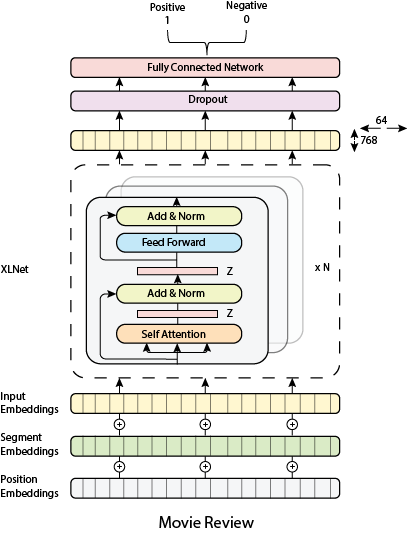

In [7]:
class XLNetModel(nn.Module):
  def __init__(self):
    super(XLNetModel, self).__init__()
    self.bert = Config.MODEL
    # self.bert_drop = nn.Dropout(0.3)
    self.out = nn.Linear(768, 1)
    torch.nn.init.xavier_normal_(self.out.weight)

  def forward(self, input_ids, attention_mask, token_type_ids):
    last_hidden_state = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
    # bo = self.bert_drop(pooled_output)
    mean_last_hidden_state = torch.mean(last_hidden_state[0], 1)
    output = self.out(mean_last_hidden_state)

    return output

### Engine

In [8]:
def loss_fn(outputs, labels):
  return nn.BCEWithLogitsLoss()(outputs, labels.view(-1, 1))

def train_fn(train_dataloader, model, optimizer, device, scheduler):
  model.train()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  for bi, d in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    token_type_ids = d["token_type_ids"]
    labels = d["labels"]

    input_ids = input_ids.to(device, dtype=torch.long)
    attention_mask = attention_mask.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype = torch.long)
    labels = labels.to(device, dtype = torch.float)

    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
    loss = loss_fn(outputs, labels)

    final_loss += loss.item()
    fin_labels.extend(labels.cpu().detach().numpy().tolist())
    fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    loss.backward()
    optimizer.step()
    scheduler.step()

  return fin_outputs, fin_labels, final_loss/len(train_dataloader)

def eval_fn(valid_dataloader, model, device):
  model.eval()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      token_type_ids = d["token_type_ids"]
      labels = d["labels"]

      input_ids = input_ids.to(device, dtype=torch.long)
      attention_mask = attention_mask.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype = torch.long)
      labels = labels.to(device, dtype = torch.float)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)

      loss = loss_fn(outputs, labels)
      final_loss += loss.item()

      fin_labels.extend(labels.cpu().detach().numpy().tolist())
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())


  return fin_outputs, fin_labels, final_loss/len(valid_dataloader)

### Train

In [9]:
dataset = MovieReviewDatSet(Config.TRAINING_DATA)

train_data, valid_data = train_test_split(dataset, test_size = 0.1)
train_dataloader = DataLoader(train_data, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=4)
valid_dataloader = DataLoader(valid_data, batch_size=Config.VALID_BATCH_SIZE, num_workers=1)

model = XLNetModel()
model.to(Config.DEVICE)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]

num_train_steps = int(len(train_data) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

history = defaultdict(list)

best_accuracy = 0
for epoch in range(1, Config.EPOCHS+1):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model, Config.DEVICE)

  train_outputs = np.array(train_outputs) >= 0.5
  valid_outputs = np.array(valid_outputs) >= 0.5

  train_accuracy = metrics.accuracy_score(train_labels, train_outputs)
  valid_accuracy = metrics.accuracy_score(valid_labels, valid_outputs)

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train Accuracy: {train_accuracy} \nValid Loss: {valid_loss} - Valid Accuracy: {valid_accuracy}\n")

  history['Train Loss'].append(train_loss)
  history['Train Accuracy'].append(train_accuracy)
  history['Valid Loss'].append(valid_loss)
  history['Valid Accuracy'].append(valid_accuracy)

  if valid_accuracy > best_accuracy:
    torch.save(model.state_dict(), Config.MODEL_PATH)
    best_accuracy = valid_accuracy

100%|██████████| 625/625 [02:33<00:00,  4.06it/s]


Epoch: 1
Train Loss: 0.22670205672294064 - Train Accuracy: 0.9131555555555556 
Valid Loss: 0.18890754350116476 - Valid Accuracy: 0.9232



100%|██████████| 625/625 [02:33<00:00,  4.06it/s]


Epoch: 2
Train Loss: 0.11395399925458155 - Train Accuracy: 0.9589333333333333 
Valid Loss: 0.2302482358713867 - Valid Accuracy: 0.9324



100%|██████████| 625/625 [02:33<00:00,  4.07it/s]

Epoch: 3
Train Loss: 0.05371839967428833 - Train Accuracy: 0.9824888888888889 
Valid Loss: 0.2663777281169547 - Valid Accuracy: 0.928




100%|██████████| 625/625 [02:33<00:00,  4.06it/s]

Epoch: 4
Train Loss: 0.020500461608848983 - Train Accuracy: 0.9944444444444445 
Valid Loss: 0.2837747077773325 - Valid Accuracy: 0.9284



### Error Analysis & Performance auditing

In [10]:
def get_metrics(labels, outputs):
  accuracy = metrics.accuracy_score(labels, outputs)
  recall = metrics.recall_score(labels, outputs)
  precision = metrics.precision_score(labels, outputs)
  f1 = metrics.f1_score(labels, outputs)
  return accuracy, recall, precision, f1


Results summary

Accuracy Score  : 0.9284
Recall Score    : 0.9275945293644409
Precision Score : 0.928341384863124
F1 Score        : 0.9279678068410463

Classification report 

               precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      1257
         1.0       0.93      0.93      0.93      1243

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500



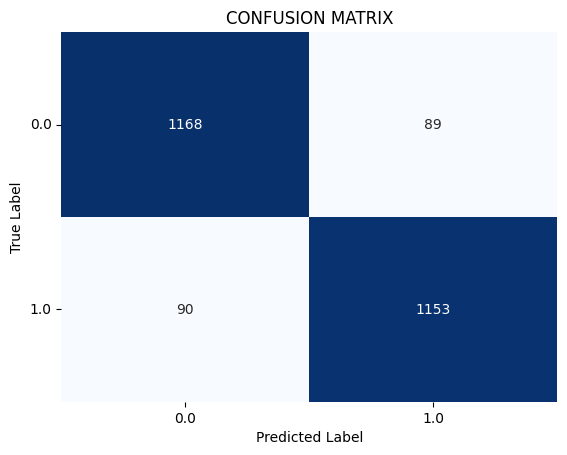

In [11]:
accuracy, recall, precision, f1 = get_metrics(valid_labels, valid_outputs)

print("==="*50)
print("\nResults summary\n")
print(f"Accuracy Score  : {accuracy}")
print(f"Recall Score    : {recall}")
print(f"Precision Score : {precision}")
print(f"F1 Score        : {f1}")

print("==="*50)
print("\nClassification report \n\n", metrics.classification_report(valid_labels, valid_outputs))

print("==="*50)
cm = metrics.confusion_matrix(valid_labels, valid_outputs)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Label",
       ylabel="True Label",
       xticklabels=np.unique(valid_labels),
       yticklabels=np.unique(valid_labels),
       title="CONFUSION MATRIX")
plt.yticks(rotation=0);

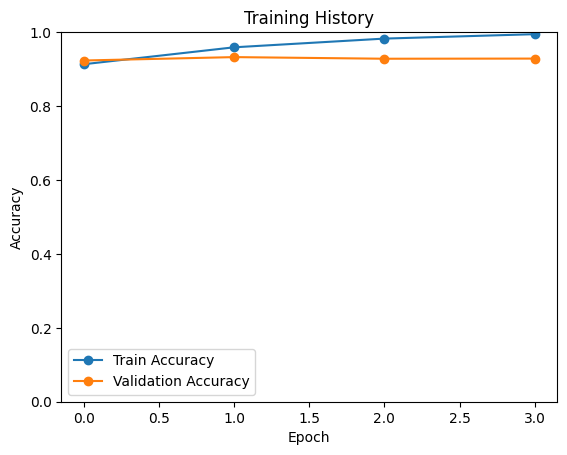

In [12]:
plt.plot(history['Train Accuracy'], '-o', label='Train Accuracy')
plt.plot(history['Valid Accuracy'], '-o', label='Validation Accuracy')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

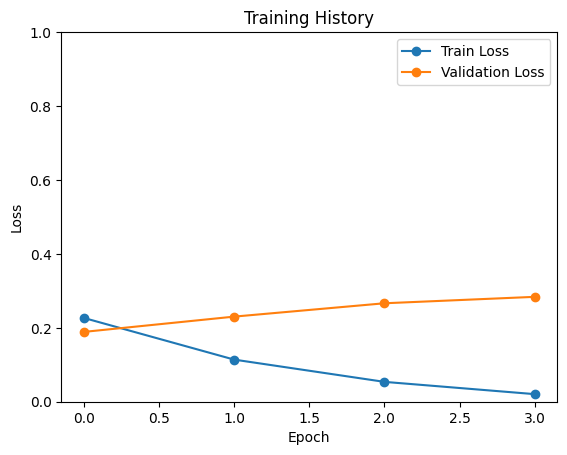

In [13]:
plt.plot(history['Train Loss'], '-o', label='Train Loss')
plt.plot(history['Valid Loss'], '-o', label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Inference

In [14]:
model = XLNetModel()
model.to(Config.DEVICE)
model.load_state_dict(
    torch.load(
        Config.MODEL_PATH,
        map_location=torch.device(Config.DEVICE)
        )
    )

def predict(review: str):
  data = DataProcess(review)
  input_ids, attention_mask, token_type_ids = data.preprocess_bert()

  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  token_type_ids = token_type_ids.to(Config.DEVICE, dtype=torch.long)

  outputs = model(input_ids, attention_mask, token_type_ids)
  positive_prediction = data.preprocess_output(outputs)
  negative_prediction = 1 - positive_prediction

  return {
      "review": review,
      "positive": str(positive_prediction),
      "negative": str(negative_prediction),
  }

In [15]:
sentiment = predict("I like this amazing movie")
print(sentiment)

{'review': 'I like this amazing movie', 'positive': '0.9968694', 'negative': '0.003130614757537842'}


### References:
* **Zhilin Yang, Zihang Dai, Yiming Yang, Jaime Carbonell, Ruslan Salakhutdinov, Quoc V. Le. 2019. [XLNet: Generalized Autoregressive Pretraining for Language Understanding](https://arxiv.org/abs/1906.08237). arXiv preprint arXiv:1906.08237.**